# Kappa Fleiss between three coders

Calculates the Kappa fleiss between three (Felipe, Guilherme, YouTube-8m) coders using two approaches: most frequent category and weighted.

In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import str2tupleList, sumOfSquares

In [2]:
%load_ext rpy2.ipython

In [3]:
ads = pd.read_csv('../processed_data/ads.csv')
cat = pd.read_csv('../processed_data/mapped_categories.csv')

In [4]:
ads['labels'] = ads['categories'].apply(str2tupleList, 1)

In [5]:
ads.head()

,videoId,categories,labels
0,-0iPHNTYfOI,"[('Food', '0.384545'), ('Vehicle', '0.0851527'...","[(Food, 0.384545), (Vehicle, 0.0851527), (Anim..."
1,-4P8-sJqukY,"[('Hot air balloon', '0.35213'), ('Balloon (ae...","[(Hot air balloon, 0.35213), (Balloon (aeronau..."
2,-5bLu-NETl0,"[('Website', '0.0725519'), ('Video game', '0.0...","[(Website, 0.0725519), (Video game, 0.0288155)..."
3,-7TzvnMnflE,"[('Cartoon', '0.805026'), ('Animation', '0.132...","[(Cartoon, 0.805026), (Animation, 0.132279), (..."
4,-8M5Ekbt2hA,"[('Video game', '0.191235'), ('Game', '0.18813...","[(Video game, 0.191235), (Game, 0.188133), (Ra..."


In [6]:
for index,row in ads.iterrows():
    tmp = []
    for x,y in row['labels']:
        tmp.append(x)
    ads.at[index, 'categories'] = tmp

In [7]:
cat_dict = dict(zip(cat['label'], cat['categories']))

In [8]:
def map_cat(lst):
    tmp = []
    for k in lst:
        try:
            tmp.append(cat_dict[k])
        except:
            pass
    return tmp

In [9]:
ads['categories'] = ads['categories'].apply(map_cat, 1)

In [10]:
cat.head()

,count,code,label,categories
0,788288,/m/03bt1gh,Games,Games
1,539945,/m/01mw1,Video game,Games
2,415890,/m/07yv9,Vehicle,Autos & Vehicles
3,378135,/m/01jddz,Concert,Arts & Entertainment
4,286532,/m/09jwl,Musician,Arts & Entertainment


## Most Frequent approach

In [11]:
def most_frequent(lst): 
    return max(set(lst), key = lst.count)

In [12]:
ads['category_youtube8m'] = ads['categories'].apply(most_frequent, 1)

In [13]:
ads.head()

,videoId,categories,labels,category_youtube8m
0,-0iPHNTYfOI,"[Food & Drink, Autos & Vehicles, Pets & Animal...","[(Food, 0.384545), (Vehicle, 0.0851527), (Anim...",Food & Drink
1,-4P8-sJqukY,"[Hobbies & Leisure, Games, Autos & Vehicles, H...","[(Hot air balloon, 0.35213), (Balloon (aeronau...",Hobbies & Leisure
2,-5bLu-NETl0,"[Internet & Telecom, Games, Computers & Electr...","[(Website, 0.0725519), (Video game, 0.0288155)...",Computers & Electronics
3,-7TzvnMnflE,"[Arts & Entertainment, Arts & Entertainment, A...","[(Cartoon, 0.805026), (Animation, 0.132279), (...",Arts & Entertainment
4,-8M5Ekbt2hA,"[Games, Games, Autos & Vehicles, Arts & Entert...","[(Video game, 0.191235), (Game, 0.188133), (Ra...",Games


In [14]:
felipe_coding = pd.read_csv("../data/felipe_coding.csv")
guilherme_coding = pd.read_csv("../data/guilherme_coding.csv")

felipe_coding = felipe_coding[['ad_id', 'what is the category of the product?']]
felipe_coding.columns = ['ad_id', 'category_felipe']
felipe_coding = felipe_coding.dropna()

guilherme_coding = guilherme_coding[['ad_id', 'what is the category of the product?']]
guilherme_coding.columns = ['ad_id', 'category_guilherme']
guilherme_coding = guilherme_coding.dropna()

In [15]:
coding = ads.copy()
coding = coding[['videoId', 'category_youtube8m']]

In [16]:
coding = coding.join(felipe_coding.set_index('ad_id'), on='videoId')
coding = coding.join(guilherme_coding.set_index('ad_id'), on='videoId')

In [17]:
coding = coding.dropna()
coding = coding.drop_duplicates()

In [18]:
coding.head()

,videoId,category_youtube8m,category_felipe,category_guilherme
98,1YBY1Hyo7ls,Games,Arts & Entertainment,Arts & Entertainment
108,1kMEXhOMznQ,Pets & Animals,Business & Industrial,Business & Industrial
116,1u2nS8jcc5g,Food & Drink,Home & Garden,Home & Garden
144,2iTNc8rsFo8,Shopping,Clothing,Clothing
156,34AJ7MJNqFg,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment


In [19]:
def fleiss_kappa(df):  
    k_list = list(set([*df.iloc[:,1], *df.iloc[:,2], *df.iloc[:,3]]))
    
    kappa_table = pd.DataFrame(0, index=df.videoId, columns=k_list)
    
    N = len(df)
    n = 3
    k = len(k_list)
    
    for _,row in df.iterrows():
        kappa_table.at[row['videoId'], row['category_youtube8m']] += 1
        kappa_table.at[row['videoId'], row['category_felipe']] += 1
        kappa_table.at[row['videoId'], row['category_guilherme']] += 1
        
    kappa_table['P'] = 1/(n*(n-1)) * (kappa_table.apply(sumOfSquares, 1) - n)
    p = kappa_table.iloc[:,:-1].sum()/kappa_table.iloc[:,:-1].sum().sum()
    
    P_hat = (1/N) * (kappa_table['P'].sum())
    P_hat_e = sumOfSquares(p)
    kappa = (P_hat - P_hat_e)/(1 - P_hat_e)
    return kappa

In [20]:
fleiss_kappa(coding)

0.33969832019197815

In [21]:
coding_r = coding.iloc[:, 1:4]

In [22]:
coding_r.shape

(103, 3)

In [29]:
%%R -i coding_r

library(irr)
kappam.fleiss(coding_r)

 Fleiss' Kappa for m Raters

 Subjects = 103 
   Raters = 3 
    Kappa = 0.34 

        z = 21.1 
  p-value = 0 


|    k        |interpretation            |
|   -------   |   -------                |
|    <0       | Poor agreement           |
|  0.01-0.20  | Slight agreement         |
| **0.21-0.40**  | **Fair agreement**           |
|  0.41-0.60  | Moderate agreement       |
|  0.61-0.80  |	Substantial agreement    |
|  0.81-1.00  | Almost perfect agreement |

## Highest weight approach

In [24]:
def highest_weight(df, cat_dict):
    df['category_youtube8m_hw'] = ""
    for index, row in df.iterrows():
        teste = pd.DataFrame(data=row.labels, columns=['label', 'weight'])
        teste['label'] = teste['label'].map(cat_dict)
        teste['weight'] = teste['weight'].astype(float)
        teste = teste.groupby(['label']).sum()
        df.at[index, 'category_youtube8m_hw'] = teste['weight'].idxmax()
        
    return df

In [25]:
ads = highest_weight(ads, cat_dict)

In [26]:
coding = ads.copy()
coding = coding[['videoId', 'category_youtube8m_hw']]
coding = coding.join(felipe_coding.set_index('ad_id'), on='videoId')
coding = coding.join(guilherme_coding.set_index('ad_id'), on='videoId')
coding = coding.dropna()
coding = coding.drop_duplicates()
coding.columns = ['videoId', 'category_youtube8m', 'category_felipe', 'category_guilherme']

In [27]:
coding.head()

,videoId,category_youtube8m,category_felipe,category_guilherme
98,1YBY1Hyo7ls,Games,Arts & Entertainment,Arts & Entertainment
108,1kMEXhOMznQ,Pets & Animals,Business & Industrial,Business & Industrial
116,1u2nS8jcc5g,Home & Garden,Home & Garden,Home & Garden
144,2iTNc8rsFo8,Shopping,Clothing,Clothing
156,34AJ7MJNqFg,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment


In [28]:
fleiss_kappa(coding)

0.3468781083280587

In [31]:
conding_r = coding.iloc[:, 1:4]

In [32]:
%%R -i coding_r

library(irr)
kappam.fleiss(coding_r)

 Fleiss' Kappa for m Raters

 Subjects = 103 
   Raters = 3 
    Kappa = 0.34 

        z = 21.1 
  p-value = 0 


## Pruning by weight

In [81]:
def prune_by_weight(df, x):
    df['category_youtube8m_pw'] = ""
    for index, row in df.iterrows():
        a = dict(row['labels'])
        b = a.copy()
        for cat, value in a.items():
            if(float(value) < x):
                if(len(b) > 1):
                    del b[cat]
        df.at[index, 'category_youtube8m_pw'] = list(b.keys())

In [82]:
prune_by_weight(ads, 0.01)

In [96]:
def best_prune(df, cat_dict, felipe_coding, guilherme_coding):
    th = np.linspace(0, 1, 101)
    kappas = []
    for x in th:
        prune_by_weight(df, x)
        df['category_youtube8m_pw'] = df['category_youtube8m_pw'].apply(most_frequent, 1)
        df['category_youtube8m_pw'] = df['category_youtube8m_pw'].replace(cat_dict)
        
        coding = df.copy()
        coding = coding[['videoId', 'category_youtube8m_pw']]
        coding = coding.join(felipe_coding.set_index('ad_id'), on='videoId')
        coding = coding.join(guilherme_coding.set_index('ad_id'), on='videoId')
        coding = coding.dropna()
        coding = coding.drop_duplicates()
        coding.columns = ['videoId', 'category_youtube8m', 'category_felipe', 'category_guilherme']
        
        kappas.append(fleiss_kappa(coding))
    return th, kappas

In [98]:
x, kappa = best_prune(ads, cat_dict, felipe_coding, guilherme_coding)

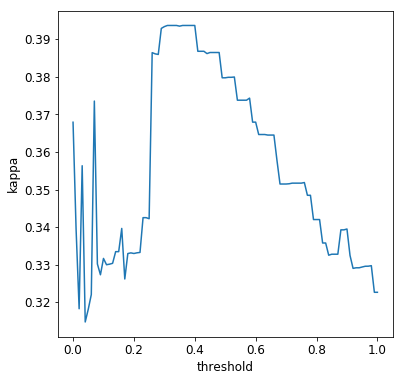

In [105]:
plt.figure(figsize=(6, 6))
plt.plot(x, kappa)
plt.ylabel("kappa", fontsize=12)
plt.xlabel("threshold", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim((0, 0.5))
plt.show()